In [1]:
import os, sys
import json
import urllib
import math

import numpy as np
from matplotlib import pyplot as plt

In [9]:
server_url = 'https://euclid-echo-homer-1.herokuapp.com'

In [7]:
def call(path, id_code='', is_post=False, is_cli=True, **kwargs):
    """
    Inputs
    ------
    path:      API endpoint (as per game help) without leading slash [string] e.g. 'move/50.1/1.6'
    id_code:   unique andro_id needed for all andro-specific commands [string]
    is_post:   [bool, default False] only needed when posting form parameters for andro ID setup
    is_cli:    [bool, default True] tells the server to return JSON confirmations in cases that
                 it would otherwise render HTML
    **kwargs:  other keyword arguments to pass either as regular parameters (is_post=False) or
                 as form parameters (is_post=True)
    """
    params = []
    if is_cli:
        params.append(('cli', 'true'))
    if id_code != '':
        params.append(('id', id_code))
    path = urllib.parse.quote(path)
    cmd = f'curl "{server_url}/{path}'
    if is_post:
        # add trailing double quote prior to form params
        cmd += '?' + urllib.parse.urlencode(params) + '"'
        for k, v in kwargs.items():
            cmd += f" --form {k}={v}"
    else:
        params.extend(list(kwargs.items()))
        cmd += '?' + urllib.parse.urlencode(params) + '"'
    #print(cmd)
    res = os.popen(cmd).read()
    try:
        return json.loads(res)
    except:
        return res
    
def make_player(name):
    info = call('make_session', is_post=True, name=name)
    try:
        assert info['success']
        return info['andro_id']
    except:
        print("Problem: " + str(info))

In [4]:
def radar_scan(andro_id, bearing):
    return call("radar/{}".format(bearing), id_code=andro_id)

def full_scan(andro_id):
    data_dict = {}
    # single scans are 30 degree arcs
    for bearing in np.linspace(0, 360, int(360/30)+1)[:-1]:
        data_dict.update(radar_scan(andro_id, bearing)['data'])     
    radar_pts = []
    for bearing, res in data_dict.items():
        radar_pts.extend([(dist*np.cos((90-float(bearing))*math.pi/180),
                           dist*np.sin((90-float(bearing))*math.pi/180), signal) \
                          for dist, signal in res])
    return radar_pts, data_dict

In [14]:
andro_id1 = make_player("Fry")

In [15]:
andro_id2 = make_player("Laurie")

In [12]:
andro_id1, andro_id2

('t_M9uVMqtVc4HQWtxYMxKw', 'S0v-spwtLXkP2A58OufJZQ')

In [16]:
call('help', id=andro_id1)

{'API info': 'These API endpoints require you to add your drone_id as a parameter. All return values are JSON and the server is JSONP compatible.',
 'Command endpoint list': ['help',
  'help/<command_name>',
  'status',
  'move/<bearing>/<distance>',
  'speak/<volume>/<message>',
  'memory/<kind>',
  'see',
  'radar/<bearing>',
  'refuel/<item_id>',
  'extract'],
 'Game info': 'Navigate your drone avatar and find the exit at the centroid of the four beacons. Collaborate or compete!'}

In [8]:
call('help/radar', id=andro_id1)

"'radar/<bearing>' returns a 30 degree spread of detected objects centered at given bearing from North. Angular accuracy is limited to the nearest degree and distance accuracy decreases for distant objects. Returns a mapping of angle to a list of (distance, reflection strength)."

In [16]:
call('status', id_code=andro_id1)

{'status': {'achievements': [],
  'devices': {'1': 'Empty', '2': 'Empty', '3': 'Empty'},
  'fuel': 99.99761743202211,
  'mass': 19.99986174320221,
  'time_elapsed': '0:00:04.243191'},
 'success': True}

In [17]:
call('see', id_code=andro_id1)

{'success': True,
 'visuals': [{'bearing': 66.21414906212286,
   'description': 'marker (J0DN13,594)',
   'distance': 6.379544167390618}]}

In [18]:
call('move/180/2', id_code=andro_id1)

{'distance': 2, 'success': True}

In [19]:
call("speak/9/how are you today? i want to talk about solving this centroid problem!", id_code=andro_id1)

{'success': True}

In [20]:
call("memory/speech", id_code=andro_id1)

{'events': [], 'success': True}

In [21]:
radar_scan(andro_id1, 60)

{'data': {'46.0': [],
  '47.0': [],
  '48.0': [],
  '49.0': [],
  '50.0': [[152.09074236550356, 0.04321242857003997]],
  '51.0': [[223.74233403536795, 0.020058710320197758],
   [7.400374404196609, 1.801832456083324]],
  '52.0': [],
  '53.0': [[121.9097354983599, 0.06639032631727422]],
  '54.0': [[211.27371810964385, 0.022497373577221112]],
  '55.0': [],
  '56.0': [],
  '57.0': [],
  '58.0': [],
  '59.0': [],
  '60.0': [],
  '61.0': [],
  '62.0': [],
  '63.0': [],
  '64.0': [],
  '65.0': [],
  '66.0': [],
  '67.0': [],
  '68.0': [],
  '69.0': [],
  '70.0': [[177.33251660244778, 0.03141109109274493]],
  '71.0': [],
  '72.0': [],
  '73.0': [],
  '74.0': []},
 'success': True}

In [22]:
radar_pts, data_dict = full_scan(andro_id1)
radar_xs, radar_ys, signals = list(zip(*radar_pts))

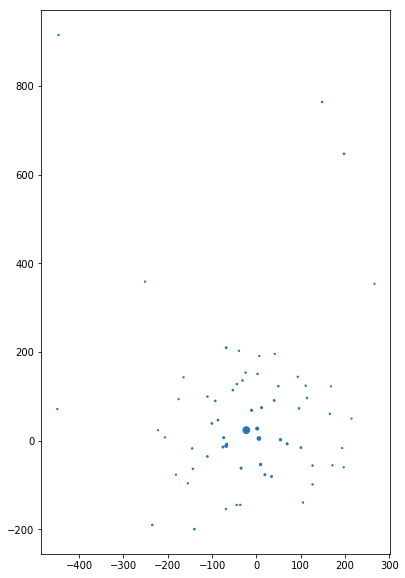

In [23]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.scatter(radar_xs, radar_ys, s=10*np.sqrt(np.array(signals)))
#ax1.set_xlim(-250,250)
#ax1.set_ylim(-250,250)
ax1.set_aspect('equal')

In [24]:
np.array(signals)

array([2.36648278e-02, 5.05984507e-02, 4.06756075e-02, 1.89654327e-01,
       4.42393006e-02, 5.29398755e-02, 2.50707050e-02, 2.74954784e-02,
       8.10412757e-01, 1.59810119e-01, 7.17109845e-02, 5.76975010e-02,
       9.86067557e-02, 3.29785723e-02, 2.51165988e-02, 3.55022670e-02,
       4.32124286e-02, 1.80183246e+00, 6.63903263e-02, 2.24973736e-02,
       3.14110911e-02, 2.04834088e-02, 2.96278621e-01, 2.57027583e-02,
       1.86002334e-01, 9.45481210e-02, 2.35415317e-02, 3.00327225e-02,
       5.00148616e-02, 3.78401755e-02, 3.25453738e-02, 1.22614318e-01,
       1.49125690e-01, 2.86038496e-01, 4.37401864e-02, 4.21310963e-02,
       3.26789890e-02, 1.81818987e-01, 8.34711298e-02, 5.41441517e-02,
       3.06908560e-02, 4.03376270e-02, 2.53957786e-02, 7.27819828e-02,
       1.55670388e-01, 6.67342337e-01, 4.38293200e-02, 1.97030482e-01,
       2.38258278e-02, 1.65040057e-01, 2.00675174e-02, 2.41278408e-02,
       8.26460563e-02, 9.61994988e-02, 2.43953010e-02, 2.06728857e-02,
      

In [26]:
call('refuel/E379J8', id_code=andro_id1)

{'data': 'no such item closer than 1m', 'success': False}